In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

z=np.array([0.07,0.09,0.12,0.17,0.179,0.199,0.20,0.27,0.28,0.352,0.3802,0.4,0.4004,0.4247,0.4497,0.47,0.4783,0.48,0.593,0.68,0.781,0.875,0.88,0.90,1.037,1.3,1.363,1.43,1.53,1.75,1.965])
Hz=np.array([69,69,68.6,83,75,75,72.9,77,88.8,83,83,95,77,87.1,92.8,89,80.9,97,104,92,105,125,90,117,154,168,160,177,140,202,186.5])
err=np.array([19.6,12,26.2,8,4,5,29.6,14,36.6,14,13.5,17,10.2,11.2,12.9,50,9,62,13,8,12,17,40,23,20,17,33.6,18,14,40,50.4])
c = 2.99792458e5
z_bao =  np.array([0.38,0.38,0.51,0.51,0.61,0.61,0.122,0.81,1.52,2.34,2.34])
Aobs_bao = np.array([1512.39,81.2087,1975.22,90.9029,2306.68,98.9647,539,10.75,3843,8.86,37.41])
C_mat = np.array([[624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778,0,0,0,0,0],
                  [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056,0,0,0,0,0],
                  [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013,0,0,0,0,0],
                  [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334,0,0,0,0,0],
                  [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327,0,0,0,0,0],
                  [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936,0,0,0,0,0],
                  [0,0,0,0,0,0,289,0,0,0,0],
                  [0,0,0,0,0,0,0,0.1849,0,0,0],
                  [0,0,0,0,0,0,0,0,21609,0,0],
                  [0,0,0,0,0,0,0,0,0,0.0841,-0.183396],
                  [0,0,0,0,0,0,0,0,0,-0.183396,3.4596],
                 ])



  0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20000/20000 [00:31<00:00, 642.00it/s]


Parameter estimates:
H0: 66.61 +5.54/-4.67
Omega_M: 0.21 +0.09/-0.10
Omega_k: 0.32 +0.24/-0.22
wx: -1.26 +0.61/-0.51


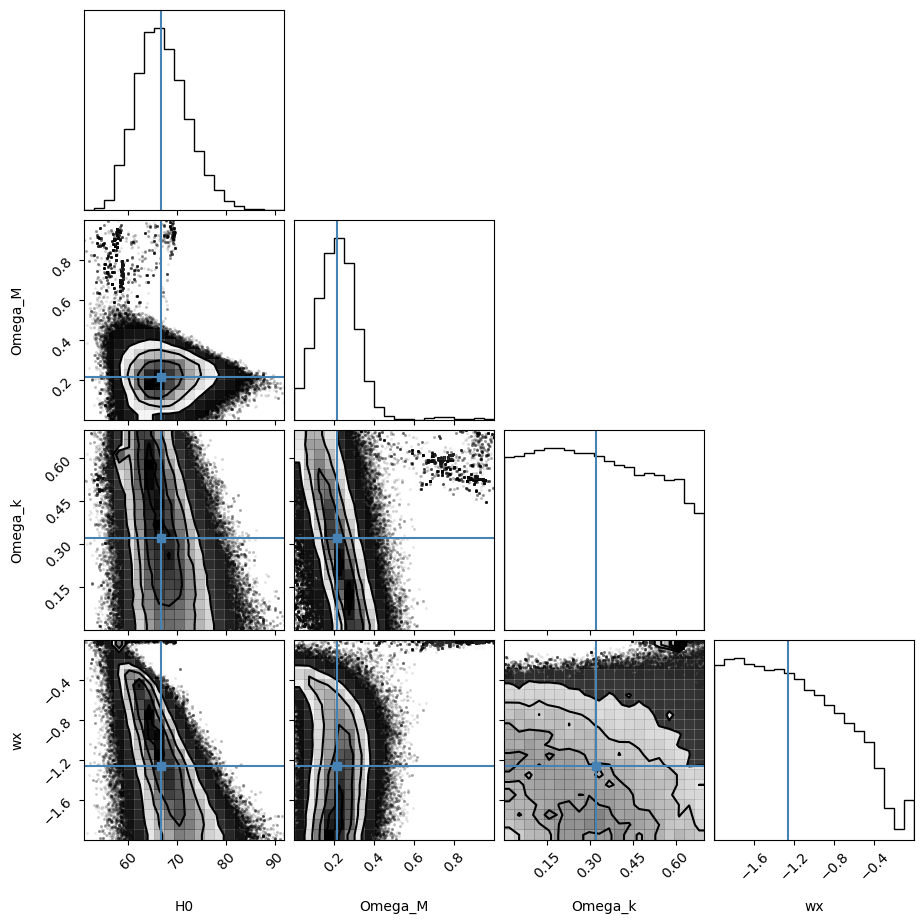

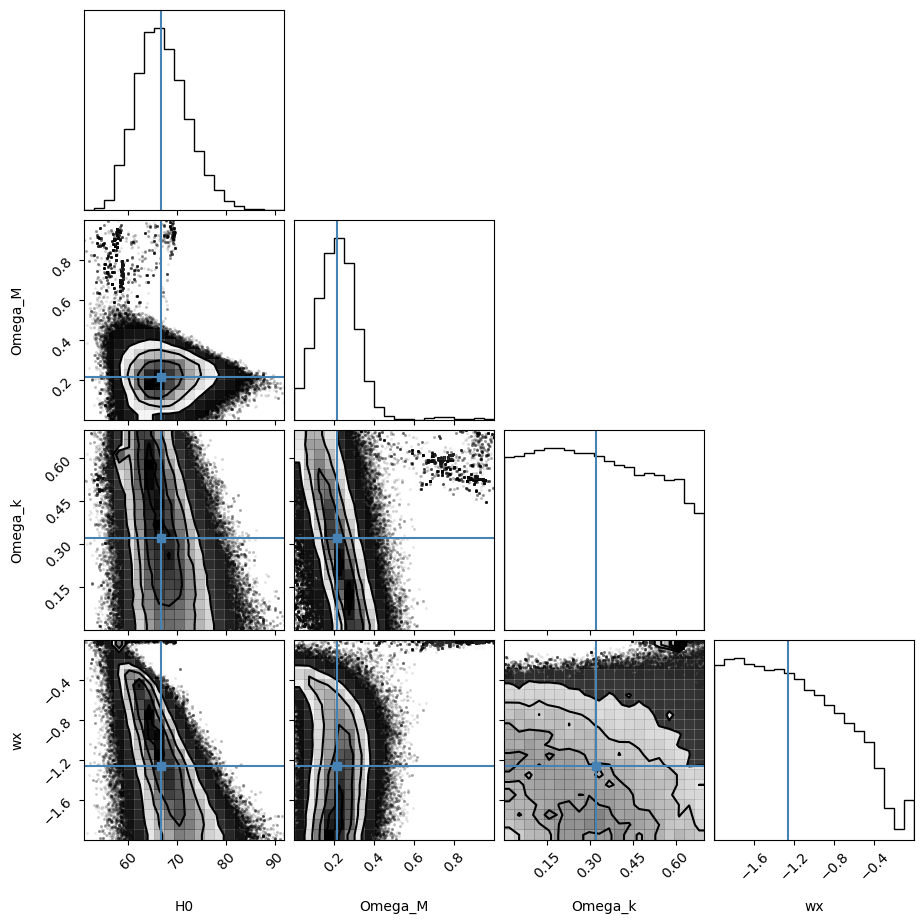

In [2]:
import numpy as np
import emcee
import corner

# Example data (replace with your actual data)
z_data = z
H_data = Hz
uncertainties = err

# Define the LCDM model and chi-squared function
def xcdm_model(params, z):
    H0, Omega_M , Omega_k , wx= params
    return H0 * np.sqrt(Omega_M * (1 + z)**3 + Omega_k* (1+z)**2 + (1 - Omega_M - Omega_k) * (1+z)**(3 * (1+wx)) ) 

def chi_squared(params, z_data, H_data, uncertainties):
    model_predictions = xcdm_model(params, z_data)
    chi_sq = np.sum(((H_data - model_predictions) / uncertainties) ** 2)
    return chi_sq

# Define log likelihood function for emcee
def log_likelihood(params, z_data, H_data, uncertainties):
    chi_sq = chi_squared(params, z_data, H_data, uncertainties)
    return -0.5 * chi_sq

# Define log prior function for emcee
def log_prior(params):
    H0, Omega_M, Omega_k , wx = params
    # Apply priors here if necessary
    if 50.0 < H0 < 100.0 and 0.0 < Omega_M < 1.0 and 0 < Omega_k < 0.7 and -2 < wx < 0:
        return 0.0
    return -np.inf

# Define log probability function for emcee
def log_probability(params, z_data, H_data, uncertainties):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, z_data, H_data, uncertainties)

# Initial guess for parameters
initial_params = [70.0, 0, 0, 0]

# Set up the emcee sampler
n_walkers = 32
n_dim = len(initial_params)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(z_data, H_data, uncertainties))

# Run the MCMC sampler
n_steps = 20000
sampler.run_mcmc(initial_params + 1e-4 * np.random.randn(n_walkers, n_dim), n_steps, progress=True)

# Get the samples from the MCMC chain
samples = sampler.get_chain(discard=100, flat=True)

# Calculate percentiles for uncertainties
percentiles = np.percentile(samples, [16, 50, 84], axis=0)

# Print and plot the results using corner plot
print("Parameter estimates:")
print("H0: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 0], percentiles[2, 0] - percentiles[1, 0], percentiles[1, 0] - percentiles[0, 0]))
print("Omega_M: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 1], percentiles[2, 1] - percentiles[1, 1], percentiles[1, 1] - percentiles[0, 1]))
print("Omega_k: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 2], percentiles[2, 2] - percentiles[1, 2], percentiles[1, 2] - percentiles[0, 2]))
print("wx: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 3], percentiles[2, 3] - percentiles[1, 3], percentiles[1, 3] - percentiles[0, 3]))

# Plot corner plot
labels = ['H0', 'Omega_M', 'Omega_k' ,'wx']
corner.corner(samples, labels=labels, truths=percentiles[1, :])

In [10]:
def Xcdm_model(Ho, Omega_M, Omega_k,wx,z):
    return Ho * np.sqrt(Omega_M * (1 + z)**3 + Omega_k* (1+z)**2 + (1 - Omega_M - Omega_k) * (1+z)**(3 * (1+wx)) )
def E(Ho, Omega_M,Omega_k,wx,z):
    term_e = Omega_M * (1 + z)**3 + Omega_k* (1+z)**2 + (1 - Omega_M - Omega_k) * (1+z)**(3 * (1+wx))
    return np.sqrt(term_e)
def DH(Ho,Omega_M, Omega_k,wx,z):
    return c/(Ho*E(Ho,Omega_M,Omega_k,wx,z))
def f(z,Ho,Omega_M,Omega_k,wx):
    return c/(Ho*E(Ho, Omega_M,Omega_k,wx,z))
def DC(Ho,Omega_M,Omega_k,wx,z):
    val,er=quad(f,0,(z), args=(Ho,Omega_M,Omega_k,wx,))
    return val
def DM(Ho,Omega_M,Omega_k,wx,z):
    if Omega_k==0:
      return DC(Ho,Omega_M,Omega_k,wx,z)
    elif Omega_k > 0:
        t1=c/(Ho*np.sqrt(Omega_k))
        t2=np.sqrt(Omega_k)*Ho*DC(Ho,Omega_M,Omega_k,wx,z)/c
        return (t1)*np.sinh(t2)
    elif Omega_k < 0:
        return (c/(Ho*np.sqrt(-Omega_k)))*np.sin(np.sqrt(-Omega_k)*Ho*DC(Ho,Omega_M,Omega_k,wx,z)/c)
def DV(Ho,Omega_M,Omega_k,wx,z):
    return ((c/Ho)*(DM(Ho,Omega_M,Omega_k,wx,z)**2)*(z/E(Ho,Omega_M,Omega_k,wx,z)))**(1/3)
def DA(Ho,Omega_M,Omega_k,wx,z):
    return DM(Ho,Omega_M,Omega_k,wx,z)/(1+z)
def rs(Ho,Omega_M):
    h = (Ho/100)
    num = np.exp(-72.3 * ((0.0014 * h**2 + 0.0006)**2))
    den = ((0.02225) ** 0.12807) * (((Omega_M - 0.0014) * h**2) ** 0.25351)
    return 55.154*num/den

rs_fid = 147.78
Wb0_hsq = np.array([0.02225,0.02305,0.02229,0.02305])

def fu(Ho,Omega_M,Omega_k,wx,z_bao):
    Ath_bao = np.zeros(11)
    D_m_range = [0,2,4]
    hub_range = [1,3,5]
    D_v_range = [6,8]
    for i in D_m_range:
        k =  z_bao[i]
        Ath_bao[i] = DM(Ho,Omega_M,Omega_k,wx,k)*rs_fid/rs(Ho,Omega_M)
    for i in hub_range:
        k =  z_bao[i]    
        Ath_bao[i] = Ho*E(Ho,Omega_M,Omega_k,wx,k)*rs(Ho,Omega_M)/rs_fid
    for i in D_v_range:
        k =  z_bao[i]
        Ath_bao[i] = DV(Ho,Omega_M,Omega_k,wx,k)*rs_fid/rs(Ho,Omega_M)
    Ath_bao[7] = DA(Ho,Omega_M,Omega_k,wx,z_bao[7])/(rs(Ho,Omega_M))
    Ath_bao[9] = DH(Ho,Omega_M,Omega_k,wx,z_bao[9])/rs(Ho,Omega_M)
    Ath_bao[10] = DM(Ho,Omega_M,Omega_k,wx,z_bao[10])/rs(Ho,Omega_M)
    return Ath_bao

In [11]:
def chi_new(para,z_bao,Aobs_bao,C_mat):
    Ho, Omega_M,Omega_k,wx=para
    Ath_bao = fu(Ho,Omega_M,Omega_k,wx,z_bao)
    p = Ath_bao - Aobs_bao
    C_inv = np.linalg.inv(C_mat)
    t1 = np.matmul(C_inv,p)
    return np.matmul(p.T, t1)
def chi_sq_XCDM_flat(para,z,Hz,err,z_bao,Aobs_bao,C_mat):
    Ho, Omega_M,Omega_k,wx=para
    chi_squared=0
    for i in range(len(z)):
           chi_squared += ((Hz[i] - Xcdm_model(Ho,Omega_M,Omega_k,wx,z[i])) / err[i]) ** 2
    return chi_squared + chi_new(para,z_bao,Aobs_bao,C_mat)

In [12]:
np.random.seed(99)
nll = lambda *args : chi_sq_XCDM_flat(*args)
H0_ini = 70
Wm0_ini = 0.024
Wk0_ini=0.001
Wx_ini=-0.01
initial = np.array([H0_ini,Wm0_ini,Wk0_ini,Wx_ini])

soln = minimize(nll, initial, args=(z,Hz,err,z_bao,Aobs_bao,C_mat),bounds=[(0,np.inf),(0,1),(-0.7,0.7),(-2,0)])
H0_opt_LCDM_flat, Wm0_opt_LCDM_flat, Wk0_opt_LCDM_flat,Wx= soln.x
print(soln)
H0_opt_LCDM_flat, Wm0_opt_LCDM_flat,Wk0_opt_LCDM_flat, Wx

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18.497059673960308
        x: [ 6.608e+01  3.312e-01 -1.641e-01 -7.415e-01]
      nit: 27
      jac: [ 1.066e-06 -2.746e-04  3.872e-05  1.812e-05]
     nfev: 140
     njev: 28
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


(66.0773514386225,
 0.33115103779587546,
 -0.16412378507909922,
 -0.7415198378365017)

In [13]:
def log_prior_XCDM_flat(opt):
    Ho, Omega_M, Omega_k, wx = opt
    if 0.1 <= Omega_M <= 0.7 and 50 <= Ho <= 85 and -0.7<Omega_k<0.7 and -2<wx<0:
        return 0.0
    return -np.inf
def log_probability_XCDM_flat(opt, z,Hz,err,z_bao,Aobs_bao,C_mat):
    lp = log_prior_XCDM_flat(opt)
    if not np.isfinite(lp):
        return -np.inf
    return lp - 0.5*chi_sq_XCDM_flat(opt,z,Hz,err,z_bao,Aobs_bao,C_mat)
pos = soln.x + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_XCDM_flat, args = (z,Hz,err,z_bao,Aobs_bao,C_mat))
sampler.run_mcmc(pos, 2000, progress = True)

100%|██████████| 2000/2000 [14:38<00:00,  2.28it/s]


State([[ 6.61315054e+01  3.07862323e-01  1.86196145e-01 -1.19279706e+00]
 [ 6.50960125e+01  3.56752339e-01 -3.04158073e-01 -6.16659903e-01]
 [ 6.67304818e+01  3.29317092e-01 -2.06852595e-01 -7.23623170e-01]
 [ 6.42008667e+01  3.13889127e-01  2.39448403e-02 -8.22157540e-01]
 [ 6.49262326e+01  3.20429803e-01 -1.87419072e-02 -8.07561307e-01]
 [ 7.07776117e+01  2.81645428e-01  1.37015102e-01 -1.42101856e+00]
 [ 6.71791195e+01  3.21275382e-01 -1.52128518e-01 -8.15300968e-01]
 [ 6.34857060e+01  3.45274327e-01 -4.86778091e-01 -5.54288988e-01]
 [ 6.76976236e+01  3.50361293e-01 -2.86892114e-01 -6.96233825e-01]
 [ 6.69623032e+01  3.07232552e-01  9.54798793e-02 -1.06040255e+00]
 [ 6.47011702e+01  3.72143147e-01 -9.77039725e-02 -7.01747516e-01]
 [ 6.92936674e+01  3.03351261e-01 -2.68999950e-01 -7.89247434e-01]
 [ 6.82459539e+01  3.33762841e-01 -1.11779373e-01 -8.65000016e-01]
 [ 6.75363457e+01  3.26978905e-01  2.39277010e-02 -9.36294101e-01]
 [ 6.52540576e+01  3.65522826e-01 -2.74042371e-01 -6.673

In [15]:
tau_XCDM_non_flat = sampler.get_autocorr_time()
print(tau_XCDM_non_flat)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [48.01536685 60.96936603 76.757762   80.18633538]

(400000, 4)


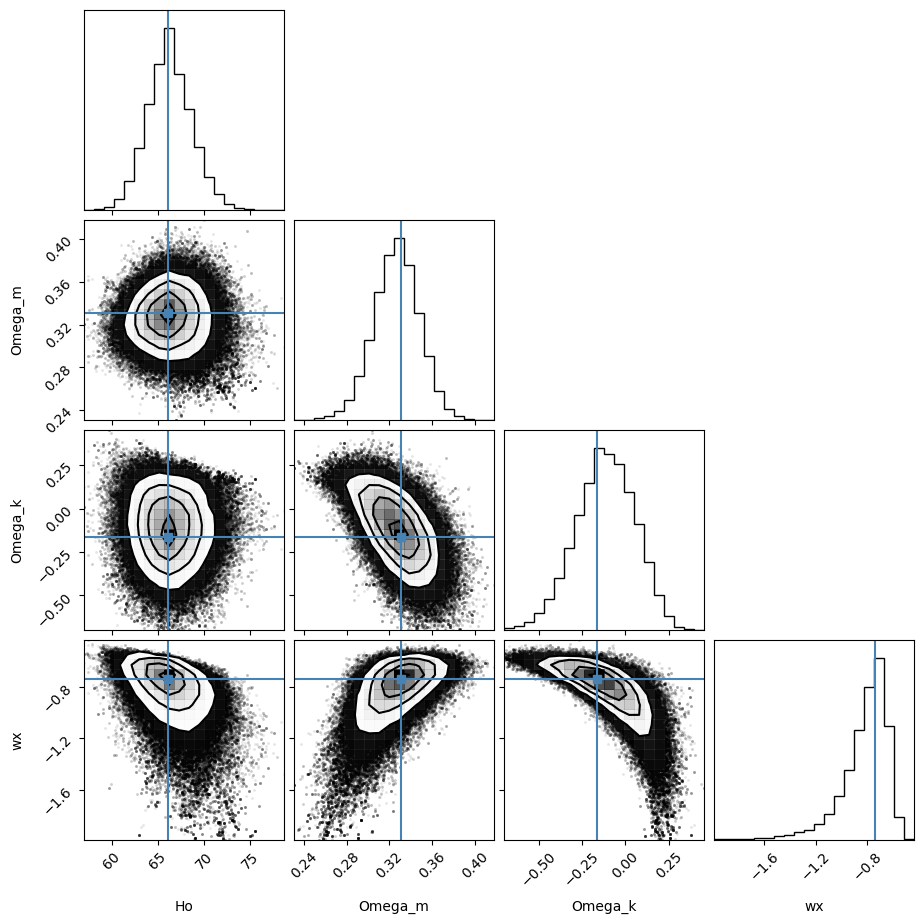

In [16]:
non_flat_samples = sampler.get_chain(flat=True)
print(non_flat_samples.shape)
labels = ["Ho", "Omega_m","Omega_k","wx"]

fig = corner.corner(
    non_flat_samples, labels=labels, truths=[H0_opt_LCDM_flat, Wm0_opt_LCDM_flat,Wk0_opt_LCDM_flat,Wx]
);

In [17]:
sampler.reset()
sampler.run_mcmc(pos,20000,progress= True)

100%|██████████| 20000/20000 [2:20:23<00:00,  2.37it/s]    


State([[ 6.21396819e+01  3.33893375e-01  4.26862003e-02 -7.08254260e-01]
 [ 6.96982854e+01  2.99809011e-01  2.38324501e-02 -1.07201124e+00]
 [ 6.63307386e+01  3.46426441e-01 -7.16628773e-02 -7.32949789e-01]
 [ 6.67508917e+01  3.42818137e-01 -2.86337096e-01 -7.03187116e-01]
 [ 6.76420088e+01  3.02969421e-01 -1.00116073e-01 -8.65470910e-01]
 [ 6.72734341e+01  3.27443825e-01 -6.68940273e-02 -8.77575140e-01]
 [ 6.54974056e+01  3.24328960e-01 -6.61039282e-03 -8.28795658e-01]
 [ 6.32194474e+01  3.06866699e-01 -1.86006495e-01 -7.01323569e-01]
 [ 6.20168060e+01  3.68741767e-01 -4.76222385e-01 -5.35233122e-01]
 [ 6.82677180e+01  3.15544506e-01 -1.80184747e-01 -8.01998572e-01]
 [ 6.40538574e+01  3.17329549e-01 -1.73703284e-01 -7.12247744e-01]
 [ 6.86363200e+01  2.80837177e-01 -1.57723758e-01 -8.47840723e-01]
 [ 6.07416158e+01  3.36890940e-01 -2.01032905e-02 -6.68521790e-01]
 [ 6.65674123e+01  3.00271118e-01  8.91858888e-02 -1.07507084e+00]
 [ 6.98150884e+01  3.34579578e-01 -2.96139669e-01 -7.674

In [18]:
tau_XCDM_non_flat = sampler.get_autocorr_time()
print(tau_XCDM_non_flat)

[ 61.89523422  94.23683908 118.49679942 154.50381883]


(4000000, 4)


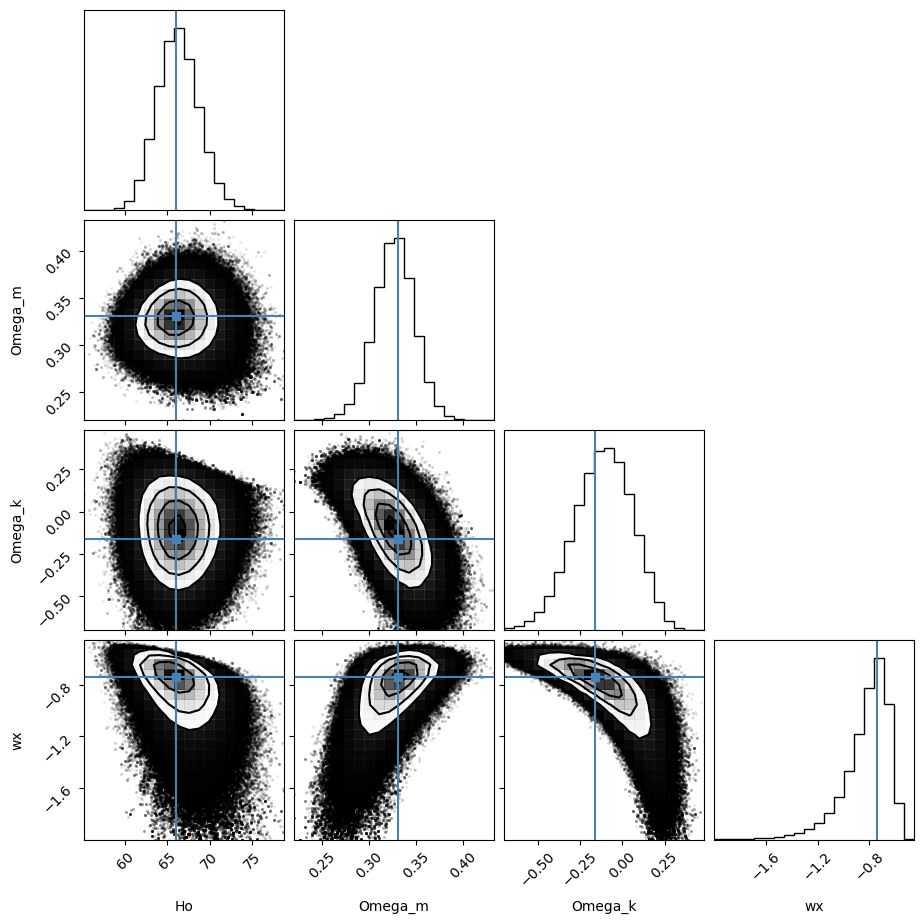

In [19]:
non_flat_samples = sampler.get_chain(flat=True)
print(non_flat_samples.shape)
labels = ["Ho", "Omega_m","Omega_k","wx"]

fig = corner.corner(
    non_flat_samples, labels=labels, truths=[H0_opt_LCDM_flat, Wm0_opt_LCDM_flat,Wk0_opt_LCDM_flat,Wx]
);

In [20]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(non_flat_samples[:, i], [16, 50, 84]) 
    q= np.diff(mcmc) 
    txt = "\mathrm{{{3}}} = {0:3}_{{-{1:.3f}}}^{{{2:.3f}}}" 
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
import getdist
from getdist import plots,MCSamples
import matplotlib.pyplot as plt
names = ["Ho","Omega_M","Omega_k","Wx"]
labels = ["H_0","\Omega_{M}","Omega_{k}","Wx"]
samples2 = MCSamples(samples=non_flat_samples,names = names, labels = labels)
means=samples2.getMeans()
stats=samples2.getMargeStats() 
conf_levels = samples2.contours
print(means)
mcmc

Removed no burn in


[66.28970272  0.32672429 -0.11321414 -0.82577283]


array([-0.98211222, -0.78290197, -0.6636741 ])

In [36]:
lims1 = stats.parWithName('Ho').limits
lims2 = stats.parWithName('Omega_M').limits 
lims3 = stats.parWithName('Omega_k').limits 
lims4 = stats.parWithName('Wx').limits 
for conf, lim1, lim2, lim3, lim4 in zip(samples2.contours,lims1, lims2, lims3, lims4):
      if conf != 0.6827:
          continue

      print('value: %.3f, lower: %.3f, upper: %.3f'.format(means[0], lim1.lower - means[0], lim1.upper- means[0]))
      print('value: %.2f, lower: %.2f, upper: %.2f'.format(means[1], lim2.lower - means[1], lim2.upper - means[1]))
      print('value: %.2f, lower: %.2f, upper: %.2f'.format(means[2], lim3.lower - means[2], lim3.upper - means[2]))
      print('value: %.3f, lower: %.3f, upper: %.3f'.format(means[3], lim1.lower - means[3], lim1.upper- means[3]))

<Figure size 600x450 with 0 Axes>

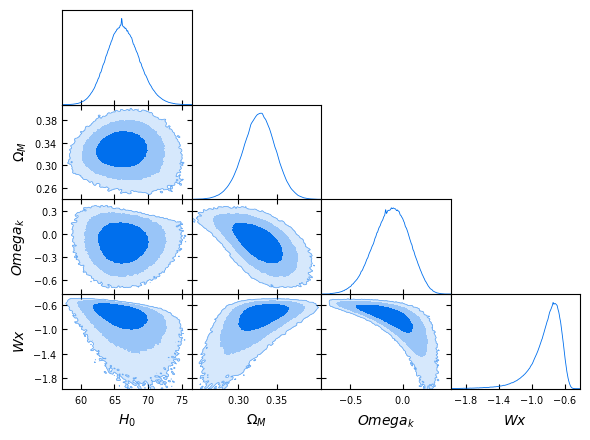

In [25]:
g = plots.get_single_plotter()
samples2.updateSettings({'contours': [0.6827, 0.9545, 0.9973]})
g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True);